In [1]:
# импорты
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import sklearn.covariance as cov
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from random import randint
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import colors as mcolors
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sompy.sompy import SOMFactory # SOM
import warnings
import logging

# отключение логгеров и предупреждений
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

# Подготовка данных

## Чтение данных, формирование датафрейма

In [2]:
# чтение данных, краткая информация по датафрейму
df = pd.read_pickle('data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798 entries, 0 to 378
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TVD      1798 non-null   float64
 1   GR       1798 non-null   float64
 2   WNKT     1798 non-null   float64
 3   DTP      1798 non-null   float64
 4   well_id  1798 non-null   object 
 5   DS_diff  835 non-null    float64
dtypes: float64(5), object(1)
memory usage: 98.3+ KB


In [3]:
# вывод заглавных (5) строк таблицы
df.head(5)

,TVD,GR,WNKT,DTP,well_id,DS_diff
0,842.031,10.257,40.069,343.124,UZ-12,NaN
1,842.130,9.947,40.314,339.601,UZ-12,NaN
2,842.228,9.366,40.060,340.717,UZ-12,NaN
3,842.327,8.050,38.385,331.685,UZ-12,NaN
4,842.426,6.654,34.709,308.736,UZ-12,NaN


In [4]:
# удаление данных, для которых отсутсвует значений DS_diff (анализ проводится только по некоторым)
df = df.loc[df['DS_diff'].isna() == False].copy()

In [5]:
# присваивание простого идентификатора записям, для избежания работы с мультииндексом номер скважины + глубина
vec_func = np.vectorize(lambda x: int(x))
df['id'] = vec_func(np.cumsum(np.ones(len(df))) - 1)

In [6]:
# создание датафрейма с метрическими переменными, по которым будут кластеризовываться данные
metric_df = df.copy()
metric_df.set_index('id', inplace=True)
metric_df.drop(columns=['well_id', 'TVD'], inplace=True)
metric_df.head(5)

,GR,WNKT,DTP,DS_diff
id,,,,
0,11.988,27.955,342.777,2.887
1,11.292,29.602,345.329,2.528
2,10.933,32.643,351.024,2.514
3,11.074,35.878,356.438,2.429
4,10.927,37.447,362.087,2.356


## Начальный анализ данных

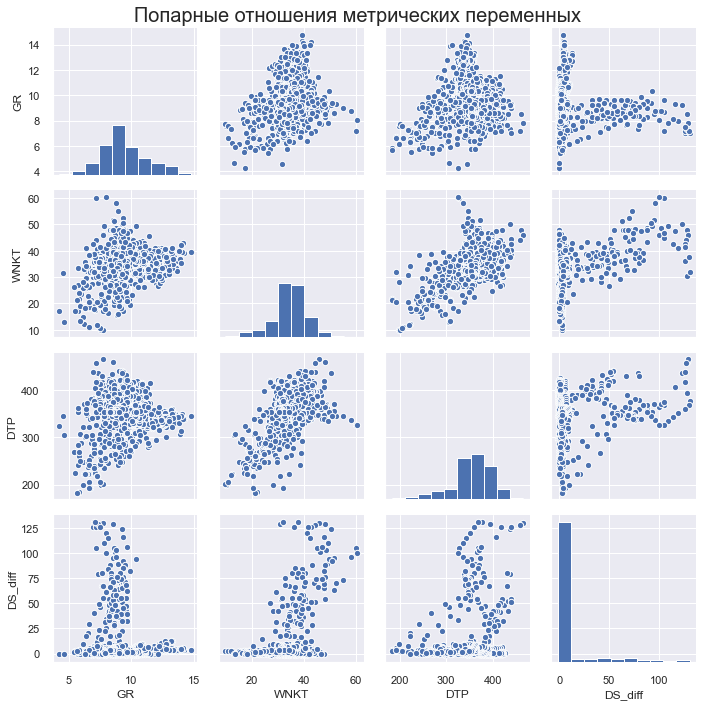

In [7]:
# попарное (две переменных) графическое отображение данных
# по диагонали - диаграммы распределения данных
def pairwise_rel(data):
    sns.set()

    # Setting pairgrid
    g = sns.PairGrid(data)

    # Populating pairgrid
    mdg = g.map_diag(plt.hist, edgecolor="w")
    mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Попарные отношения метрических переменных", fontsize=20)

    plt.show()
    
pairwise_rel(metric_df)

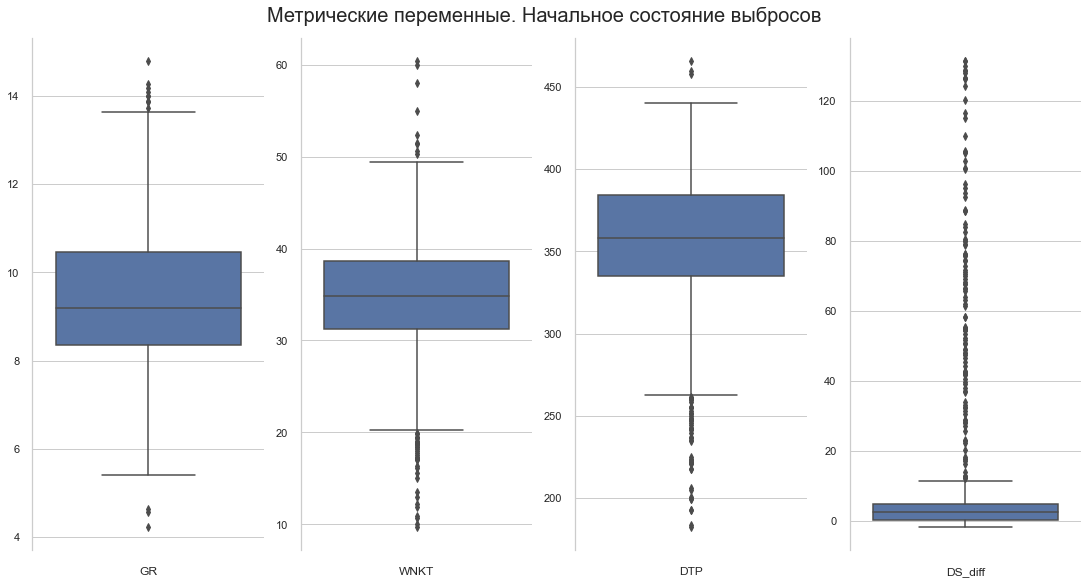

In [8]:
# box plot (ящик с усами) для отображения унивариативных выбросов в датасете (выдросы по каждой переменной отдельно)
def plot_outliers(title, data):
    sns.set(style="whitegrid")

    # Prepare dataframe layout
    plot_features = list(data.columns)

    #Prepare figure layout
    fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)

    # Draw the boxplots
    for i in zip(axes, plot_features):
        sns.boxplot(y=i[1], data=data[[i[1]]], ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")

    # Finalize the plot
    plt.suptitle(title, fontsize=20)
    sns.despine(bottom=True)

    plt.show()

plot_outliers("Метрические переменные. Начальное состояние выбросов", metric_df)

## Преобразование и подготовка данных

In [9]:
# применение преобразования по переменным (featurewise) для приближение распределения значений к гауссовому (нормальному)
# использование двух способов
yj = PowerTransformer(method='yeo-johnson')
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=np.random.RandomState(104))

# трансформация данных
X_trans_yj = yj.fit_transform(metric_df)
X_trans_qt = qt.fit_transform(metric_df)

# объединение данных в единый numpy массив
X_trans = np.concatenate((X_trans_yj, X_trans_qt), axis=1)

# создание объединенного датафрейма
merge_labels = list(map(lambda x: "yj_" + x, metric_df.columns.to_list()))+list(map(lambda x: "qt_" + x,
                    metric_df.columns.to_list()))
trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=metric_df.index)

In [10]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [11]:
# определение выбросов с использованием модели IQR (interquantile range), IQR - межквартильный размах
def out_iqr(data, k=1.5, return_thresholds=False):
    # расчет межквартильного размаха
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # расчет границ отсечения
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # идентификация выбросов
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

outlier_labels = pd.concat([out_iqr(transyj_df, 2), out_iqr(transqt_df, 2)], axis=1)

In [12]:
# мультивариативные выбросы с использованием расстояния Махаланобиса
# основано на IQR, примененном к каждой колонке в отдельности
# мультивариативные выбросы - выбросы сразу по всему набору переменных
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # получение расстояния Махаланобиса от каждого элемента до центра и сортировка по этому расстоянию
    ee_out = cov.EllipticEnvelope(contamination=0.03, support_fraction=0.95, random_state=np.random.RandomState(304)).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # получение альфа-квантиля (персентиля) распределения для каждого элемента
    quantiles = chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # присвоение меток каждому элеменнту
    labels = ee_out.predict(data)
    
    return mahalan, quantiles, labels

mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)
lqt_lyj = pd.DataFrame({'lqt': lqt, 'lyj': lyj})

In [13]:
# проверка процента выбросов
inl = lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1)].sum()['lqt']
'Процент выбросов: {:4.2f}%'.format(100 - inl/len(lqt_lyj) * 100)

'Процент выбросов: 4.19%'

In [14]:
# создание маски для исключения выбросов из таблицы
lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1), 'mask'] = True
lqt_lyj.fillna(False, inplace=True)
lqt_lyj.drop(columns=['lqt', 'lyj'], inplace=True)

In [15]:
# установка маски
main_data = metric_df.merge(lqt_lyj, left_index=True, right_index=True)
try:
    cleaned_data = main_data.loc[main_data['mask'] == True].copy()  
except:
    print('Маска не была установлена')

In [16]:
# удаление колонки маски в очищенном от выбросов датафрейме
cleaned_data.drop(columns=['mask'], inplace=True)

In [17]:
# определение количества удаленных измерений
rows_after_iqr = len(cleaned_data)
print("Количество строк после удаления выбросов", rows_after_iqr)
print("Удалено {} измерений".format(len(df) - len(cleaned_data)))

Количество строк после удаления выбросов 800
Удалено 35 измерений


In [18]:
# получена таблица с исключенными выбросами
print(cleaned_data.shape)
cleaned_data.head(3)

(800, 4)


,GR,WNKT,DTP,DS_diff
id,,,,
0,11.988,27.955,342.777,2.887
1,11.292,29.602,345.329,2.528
2,10.933,32.643,351.024,2.514


In [19]:
# объединим полученную таблицу с исключенными выбросами и начальный индекс
clusterized = cleaned_data.merge(df[['well_id', 'TVD', 'id']], left_index=True, right_on='id')

In [20]:
# в полученную таблицу в дальнейшем будут добавляться метки кластеров, полученные в различных моделях
print(clusterized.shape)
clusterized.head(3)

(800, 7)


,GR,WNKT,DTP,DS_diff,well_id,TVD,id
0,11.988,27.955,342.777,2.887,Uz_21,894.555,0
1,11.292,29.602,345.329,2.528,Uz_21,894.655,1
2,10.933,32.643,351.024,2.514,Uz_21,894.755,2


## Проверка обработанных данных

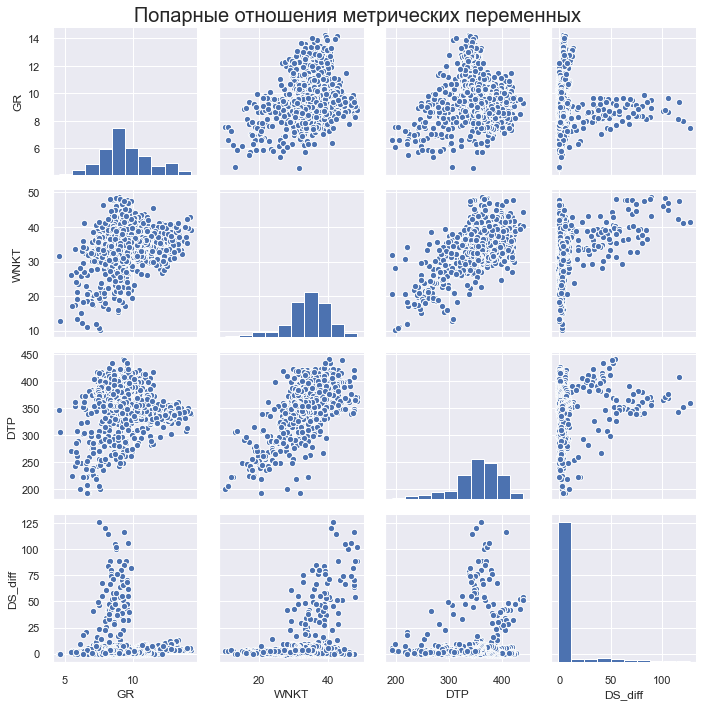

In [21]:
# графическое отображения попарных отношений переменных после удаления выбросов
pairwise_rel(cleaned_data)

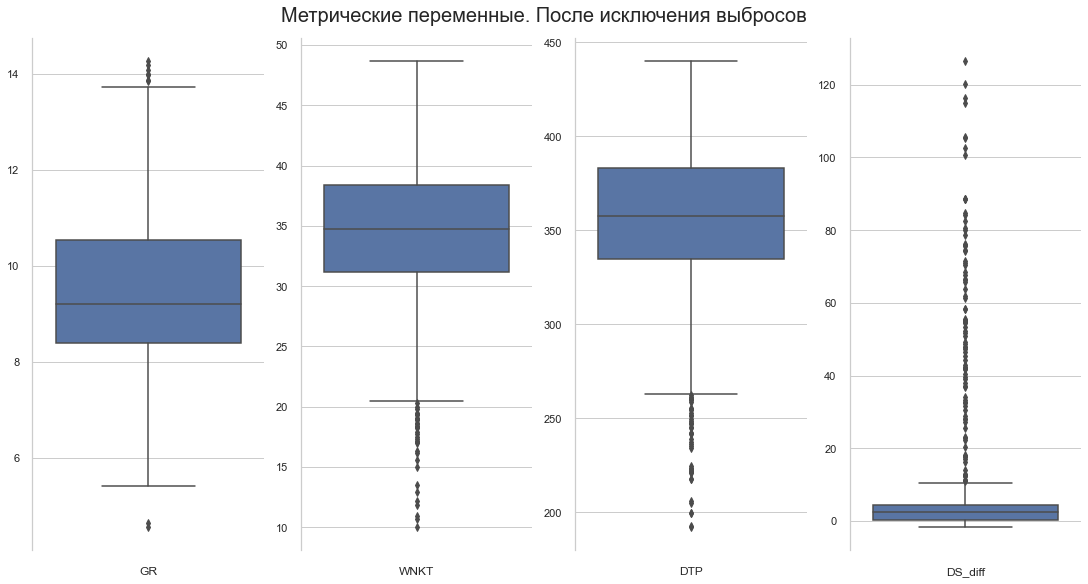

In [22]:
plot_outliers("Метрические переменные. После исключения выбросов", cleaned_data)

In [23]:
# метод построения матрицы корреляции
def plot_corr_matrix(metric_df, abs_apply=False, values=False, fig_size = (7, 7)):    
    sns.set(style="white")

    # расчет корреляционной матрицы с использованием pandas
    corr = metric_df.corr()
    if abs_apply == True:
        corr = corr.apply(np.abs)
    
    # генерация маски для верхнего треугольника
    mask = np.zeros_like(corr, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True

    # создание экземпляра класса matplotlib figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Генерация карты цветов 
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
        
    # Отображение HeatMap и коррекция масштаба
    if values:
        mask_annot = np.absolute(corr.values)>=0.70
        annot_arr = np.where(mask_annot, corr.values.round(2), np.full(fig_size,""))
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")
    else:
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

    # отображение фигуры matplotlib
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Матрица корреляции", fontsize=20)
    plt.yticks(rotation=0)
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)

    plt.show()

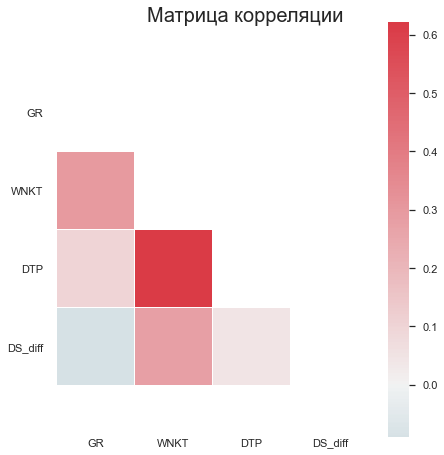

In [24]:
plot_corr_matrix(cleaned_data)

# Кластеризация

## Подготовка используемых инструментов

In [25]:
# метод отображения K-elbowplot: метрика кластеризации
def kelbowplots(clus_estim, data):
    """
    Метод отображает три метрики: "Distortion", "Silhouette" and "Calinski Harabasz"
    для различного количества кластеров с использованием заданной модели clust_estim
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # построение
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Мера риска искажения", "Коэффициент силуэта", "Критерий Calinski Harabasz"]
    titles = ["График меры риска искажения", "График значения силуэта", "График критерия Calinski Harabasz"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=False, ax=ax).fit(data)
        ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Количество кластеров", fontsize=13)
        ax.set_title(tl, fontsize=13)

    plt.suptitle("Графики K-Elbow", fontsize=20)

    plt.show()

In [26]:
def comp_gmm_models(df, max_nclus, min_nclus=2):
    """
    Столбчатая диаграмма критериев (AIC, BIC) для определения предпочтительной конфигурации GMM модели
    """
    # Data
    n_components_range = range(min_nclus, max_nclus+1)
    cv_types = ['spherical', 'tied', 'diag', 'full']  # значения типа ковариации
    bic = np.empty((4, len(n_components_range)))
    aic = np.empty((4, len(n_components_range)))
    for r, cv_type in enumerate(cv_types):
        for c, n_components in enumerate(n_components_range):
            # GM модель для разных типов ковариации EM
            gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(df)
            # сохранение значений качественных критериев
            bic[r, c] = gmm.bic(df)
            aic[r, c] = gmm.aic(df)
    
    # отображение столбчатых диаграм
    bic = pd.DataFrame(bic, columns=n_components_range, index=cv_types)
    aic = pd.DataFrame(aic, columns=n_components_range, index=cv_types)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,7))
    
    sns.barplot(data=bic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax1)
    
    sns.barplot(data=aic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax2)

    # определение параметров визуализации
    ax1.set_xlabel('Количество компонент')
    ax2.set_xlabel('Количество компонент')
    ax1.set_ylabel('Критерий BIC')
    ax2.set_ylabel('Критерий AIC')
    ax1.legend(title="Тип ковариации")
    ax2.legend(title="Тип ковариации")
    plt.suptitle('Значения BIC и AIC для моделей', fontsize=23)

    plt.show()

In [27]:
def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    Функция рассчитывает коэффициент силуэта для каждого наблюдения и строит график силуэта
    Используется для определения оптимального количества кластеров
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))
    
    sns.set()
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # если необходимо построить силуэт только для одного кластера
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        # получение названия параметра модели, определяющего количество кластеров
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Модель не имеет гиперпараметра для определения количества кластеров")
            return None
        
        # получение меток кластеров
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # Silhouette_score дает среднее значение для всех наблюдений
        # Это дает представление о плотности и разделении сформированных кластеров
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Расчет silhouette scores для каждого наблюдения
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # Диапазон silhouette coefficient [-1; 1]
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # Вставка разделителей между кластерами
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # инициализация y_lower
        for i in range(n_clusters):
            # Агрегация silhouette scores для наблюдения, относящихся к одному кластеру
            # и сортировка таких наблюдений
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Установка меток на отображении каждого кластера
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Расчет нового y_lower для следующего графика
            y_lower = y_upper + 10  # 10 для 0 наблюдений
        
        ax.set_title("{} кластера (-ов)".format(n_clusters), fontsize=13)
        ax.set_xlabel("Коэффициент силуэта")
        ax.set_ylabel("Метки кластеров")
        ax.set_yticks([])  # Удаление меток оси Y
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Средний коэффициент силуэта") # Вертикальная прямая, определяющая среднее значение
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Средний коэффициент = {0:.2f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Профили кластеров для разного количества кластеров"), fontsize=23, fontweight='bold')
    plt.show()

In [28]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):
    """
    Эта функция вычисляет R2 для набора кластерных решений, заданных применением иерархического метода.
    R2 - это мера однородности кластерного решения. Он основан на том, что Сумма квадратов (SSt) всех данных
    можно разложить на сумму SS в кластерах (SSw) и SS между кластерами (SSb): SSt = SSw + SSb. R2 - это соотношение между
    SSb и SSt: R2 = SSb / SSt. Чем выше R2, тем лучше решение, поскольку SSw будет близко к 0, что указывает на идеальную однородность
    кластеры.
    """
    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() # возврат суммы квадратов матрицы
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) # полная сумма квардратов
    
    r2 = np.array([]) # массив записи метрики R2
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() # расчет ssw метрики для заданной модели кластеризации
        r2 = np.append(r2, (sst-ssw)/sst) # запись рассчитанного R2 для заданной модели кластеризации
        
    return r2

In [29]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Отображение parallel plot для средних значений переменных в каждом кластере
    Гистограмма количества элементов полученных кластеров
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Фильтрация df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Определение центроид и количества элементов в кластере
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Построение графиков
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        # Настройка отображения графиков
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Номер кластера - {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # подстройка под количество кластеров
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Средние кластеров - {} кластера (-ов)".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Абсолютная частота")
        ax[1].set_title("Размер кластеров - {} кластера (-ов)".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Профайл кластеров", fontsize=23)
    plt.show()

In [30]:
# номировка данных, т.к. необходимо чтобы все параметры (переменные) имели одинаковую важность
scaler = StandardScaler()
std_df = pd.DataFrame(scaler.fit_transform(cleaned_data), index=cleaned_data.index, columns=cleaned_data.columns)

## Модель K-Means

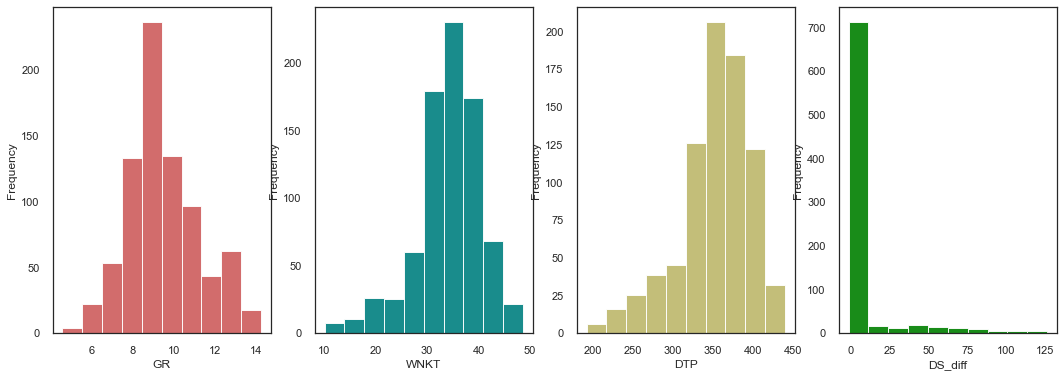

In [31]:
# проверка типа распределения данных (по переменным, columnwise) перед кластеризацией
fig, axes = plt.subplots(1, 4, figsize=(18,6))
for col, ax, color in zip(cleaned_data, axes, ['indianred', 'teal', 'darkkhaki', 'green']):
    cleaned_data[col].plot.hist(ax=ax, alpha=0.9, color=color, ylabel='Частота')
    ax.set_xlabel(col)
plt.show()

### Поиск оптимального количества кластеров

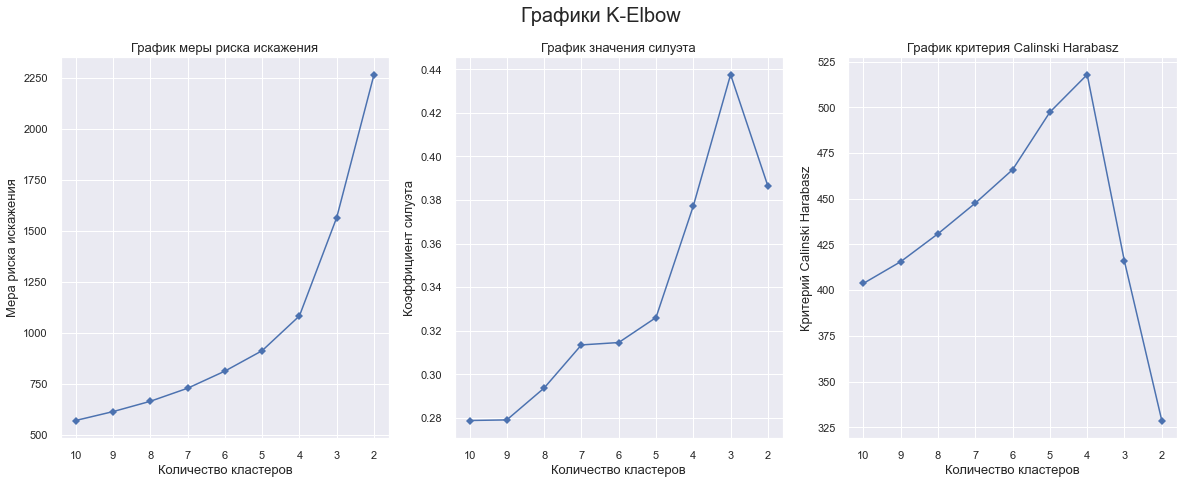

In [32]:
# инициализация K-Means модели
clus_estim = KMeans(random_state=0)

# построение K-elbow
kelbowplots(clus_estim, std_df)

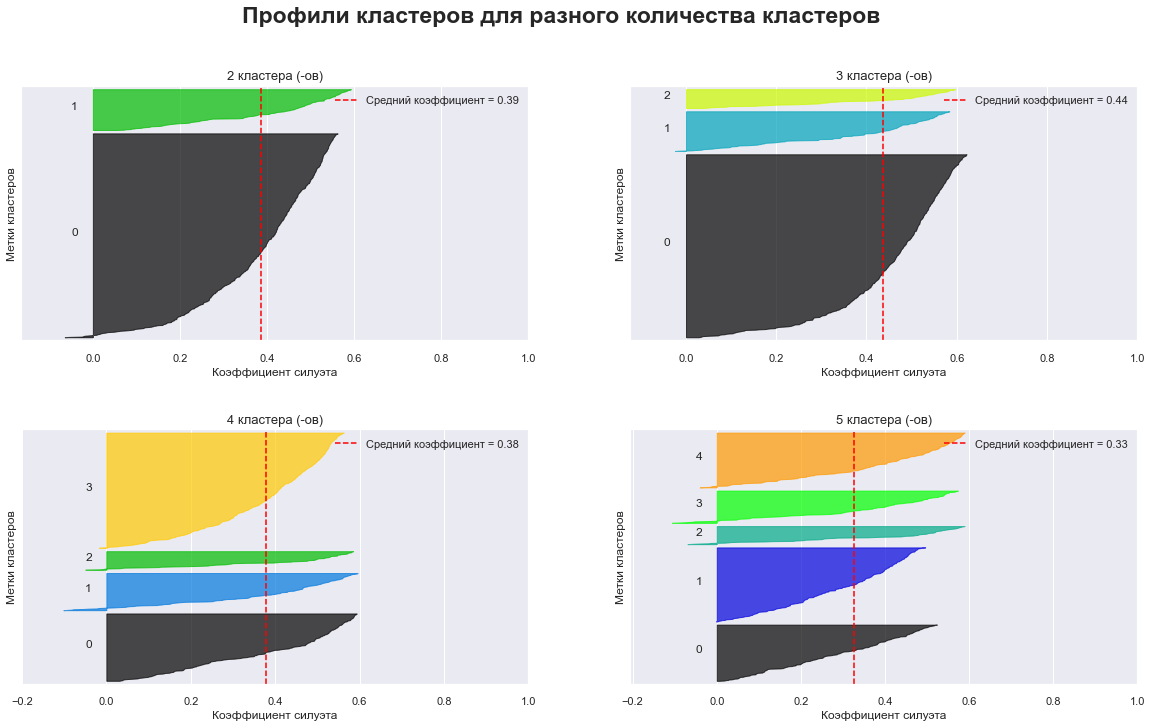

In [33]:
silhouette_analysis(std_df, clus_estim, (2,2), (20, 11), 5)

In [34]:
# определение кластеров с использованием модели K-Means
def make_clusters(n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    df_res = std_df.copy()
    df_res['cluster'] = kmeans.fit_predict(np.array(std_df))
    return df_res

In [ ]:
# parallel plot для разного количества кластеров
f, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 7))
for i, ax in zip(range(2, 5), axs.flatten()):
    df_res = make_clusters(i)
    pd.plotting.parallel_coordinates(df_res, 'cluster', color=list(mcolors.TABLEAU_COLORS.values()), ax=ax)
    ax.tick_params(labelrotation=60)
    ax.set_title('Количество кластеров ' + str(i))

plt.suptitle("Parallel plot для разного количества кластеров", fontsize=24)
plt.show()

### Кластеризация

In [ ]:
#K means кластеризация
def doKMeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return clust_labels, cent

clusters, cent = doKMeans(std_df, 3)
clusterized['kmeans_labels']= clusters

### Визуализация результатов

In [ ]:
kmeans_std_df = std_df.copy()
kmeans_std_df['clusters'] = list(clusterized['kmeans_labels'])
cluster_profiles(kmeans_std_df, ["clusters"], (23, 7))

In [ ]:
# scatter plot для полученной кластеризации (нормированные данные)
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['kmeans_labels'], s = 20, cmap = 'inferno')
    ax.scatter(cent.T[list(std_df.columns).index(var_pair[0])], cent.T[list(std_df.columns).index(var_pair[1])],
               c = 'blue', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (нормированные данные)', fontsize=18)
plt.show()

In [ ]:
# scatter plot для полученной кластеризации (исходные данные)
pairs = combinations(clusterized[std_df.columns], 2)
original_centroids = scaler.inverse_transform(cent)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['kmeans_labels'], s = 20, cmap = 'inferno')
    ax.scatter(original_centroids.T[list(std_df.columns).index(var_pair[0])],
               original_centroids.T[list(std_df.columns).index(var_pair[1])],
              c = 'blue', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (исходные данные)', fontsize=18)
plt.show()

In [ ]:
# отображение измерений в разрезе скважин

# параметр ширины отображения скважины (доля от диапазона оси X)
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 3))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['kmeans_labels'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Отображение измерений в разрезе скважин', fontsize=20)
plt.show()

## Gaussian Mixture Model (GMM)

### Определение количества кластеров

In [ ]:
comp_gmm_models(std_df, 5)

In [ ]:
estimator = GaussianMixture()
silhouette_analysis(std_df, estimator, (2,2), (20, 11), 5)

### Кластеризация

In [ ]:
# определение кластеров с использованием модели GMM
def make_clusters_gmm(df, nclust):
    model=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    return(clust_labels)

In [ ]:
# разбиения на 4 кластера с использованием модели GMM
clusterized["gmm_labels"] = make_clusters_gmm(std_df, 4)

### Сравнительный анализ и визуализация

In [ ]:
gmm_std_df = std_df.copy()
gmm_std_df['clusters'] = list(clusterized['gmm_labels'])
cluster_profiles(gmm_std_df, ["clusters"], (23, 7))

In [ ]:
# сравнительный parallel plot для K-Means и GMM
f, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(24, 7))
std_df_kmeans = std_df.copy()
std_df_kmeans['labels'] = list(clusterized.kmeans_labels)
std_df_gmm = std_df.copy()
std_df_gmm['labels'] = list(clusterized.gmm_labels)
pd.plotting.parallel_coordinates(std_df_kmeans, 'labels', color=list(mcolors.TABLEAU_COLORS.values()), ax=axs[0])
pd.plotting.parallel_coordinates(std_df_gmm, 'labels', color=list(mcolors.TABLEAU_COLORS.values()), ax=axs[1])
axs[0].tick_params(labelrotation=60)
axs[1].tick_params(labelrotation=60)
axs[0].set_title('K-Means')
axs[1].set_title('GMM')

plt.suptitle("Parallel plot для сравнения примененных моделей", fontsize=24)
plt.show()

In [ ]:
# scatter plot для полученной кластеризации
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['gmm_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (нормированные данные)', fontsize=18)
plt.show()

In [ ]:
# scatter plot для полученной кластеризации (исходные данные)
pairs = combinations(clusterized[std_df.columns], 2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['gmm_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (исходные данные)', fontsize=18)
plt.show()

In [ ]:
# отображение измерений в разрезе скважин

# параметр ширины отображения скважины (доля от диапазона оси X)
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['gmm_labels'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Отображение измерений в разрезе скважин', fontsize=20)
plt.show()

## Hierarchical Clustering (HC, иерархическая кластеризация)

### Расчет метрик для разного количества кластеров

In [ ]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=std_df, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("Значение метрики R2 для разных методов HC", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="Метод HC", title_fontsize=13)
plt.xlabel("Количество кластеров", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

In [ ]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(std_df, method=HCM)

In [ ]:
sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=10.2, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(10.5, 0, 1000, colors="r", linestyles="dashed")
plt.title('Иерархическая кластеризация - диаграмма Варда', fontsize=23)
plt.xlabel('Элементы SOM', fontsize=13)
plt.ylabel('Евклидово расстояние', fontsize=13)
plt.show()

In [ ]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Hclustering = AgglomerativeClustering(linkage=HCM)
# K-elbow plots
kelbowplots(Hclustering, std_df)

In [ ]:
# Function defined above
estimator = AgglomerativeClustering(affinity="euclidean", linkage=HCM)
silhouette_analysis(std_df, estimator, (2,2), (20, 11), 5)

### Кластеризация

In [ ]:
# определение кластеров с использованием модели HC
def make_clusters_hc(df):
    model=AgglomerativeClustering(affinity="euclidean", linkage=HCM)
    model.fit(df)
    clust_labels = model.labels_
    return(clust_labels)

In [ ]:
# разбиения на кластеры с использованием модели HC
clusterized["hc_labels"] = make_clusters_hc(std_df)

### Анализ и визуализация результатов

In [ ]:
hc_std_df = std_df.copy()
hc_std_df['clusters'] = list(clusterized['hc_labels'])
cluster_profiles(hc_std_df, ["clusters"], (23, 7))

In [ ]:
# scatter plot для полученной кластеризации
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['hc_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (нормированные данные)', fontsize=18)
plt.show()

In [ ]:
# scatter plot для полученной кластеризации (исходные данные)
pairs = combinations(clusterized[std_df.columns], 2)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['hc_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (исходные данные)', fontsize=18)
plt.show()

In [ ]:
# отображение измерений в разрезе скважин

# параметр ширины отображения скважины (доля от диапазона оси X)
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['hc_labels'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Отображение измерений в разрезе скважин', fontsize=20)
plt.show()

## Self-Organizing Maps (SOM) + K-means

### Определение оптимального количества кластеров

In [ ]:
#Producing SOM clustering based on proportional product data
sm = SOMFactory().build(data=std_df.values, 
                        mapsize=(10,10),
                        normalization='var',
                        initialization='random',
                        component_names=std_df.columns,
                        lattice='hexa',
                        training='seq')

sm.train(n_job=6,
         verbose=None,
         train_rough_len=100,
         train_finetune_len=100)

#Obtaining SOM's BMUs labels
som_std_df = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1),
                               index=std_df.index, columns=np.append(std_df.columns,"labels_som"))

print("SOM quantization error: {0:.3f}".format(sm.calculate_quantization_error()))

In [ ]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Kmeans = KMeans(random_state=0)
# K-elbow plots
som_units = som_std_df.groupby("labels_som").mean()
kelbowplots(Kmeans, som_units)

In [ ]:
# Function defined above
estimator = KMeans(random_state=0)
silhouette_analysis(som_units, estimator, (2,2), (20, 11), 5)

### Кластеризация

In [ ]:
# Defining numbers of clusters
CLUSN = 4

# KMeans with sklearn
estimator = KMeans(n_clusters=CLUSN)
labels = estimator.fit_predict(som_units)

# Getting the KMeans labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_kmeans_4"]))

# Getting the KMeans labels for each observation in the main dataframe
som_kmeans_prop_df = som_std_df.merge(right=som_units_hc.loc[:,"labels_som_kmeans_4"], 
                                           left_on="labels_som", right_index=True).sort_index()

# Cluster Simple Profilling
cluster_profiles(som_kmeans_prop_df.drop("labels_som", axis=1), ["labels_som_kmeans_4"], (23, 7))

### Анализ и визуализация результатов

In [ ]:
clusterized['som_kmeans'] = list(som_kmeans_prop_df['labels_som_kmeans_4'])
clusterized['som_kmeans'] = clusterized['som_kmeans'].apply(int)

In [ ]:
# scatter plot для полученной кластеризации
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['som_kmeans'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (нормированные данные)', fontsize=18)
plt.show()

In [ ]:
# scatter plot для полученной кластеризации (исходные данные)
pairs = combinations(clusterized[std_df.columns], 2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['som_kmeans'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (исходные данные)', fontsize=18)
plt.show()

In [ ]:
# отображение измерений в разрезе скважин

# параметр ширины отображения скважины (доля от диапазона оси X)
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['som_kmeans'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Отображение измерений в разрезе скважин', fontsize=20)
plt.show()

# Сохранение данных для дальнейшего анализа

In [ ]:
clusterized.head(5)

In [ ]:
clusterized.drop(columns=['id'], inplace=True)
clusterized.to_excel('full_data_clusterized.xlsx')